# SPOTIFY Data Analysis

BENYAHIA Hikmet

## Import libraries

In [1]:
!pip install pyspark

     |████████████████████████████████| 281.4 MB 30 kB/s               
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=3cf8d9b0d8efd00fe019017cde1a4f066364e9ce2eee72519d2c9a38044d1594
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


In [2]:
import numpy as np
import pandas as pd
from wordcloud import WordCloud

import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
import pyspark.sql.types as t
import pyspark.sql.functions as f

# Import Data

In [3]:
data = pd.read_csv('/kaggle/input/spotify-charts/charts.csv')

Get the shape of data frame:

In [4]:
data.shape

(26173514, 9)

The number of countries:

In [5]:
len(data['region'].unique())

70

# Get the visualization of artist popularity

In [6]:
def visualize_word_counts(counts):
    wc = WordCloud(max_font_size=130, min_font_size=25, colormap='tab20', background_color='white', 
                   prefer_horizontal=.95, width=2100, height=700, random_state=0)
    cloud = wc.generate_from_frequencies(counts)
    plt.figure(figsize=(18,15))
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [7]:
counts = data['artist'].value_counts()

This counts and sorts all observations of songs by artists in 70 countries in Spotify's Top200:

The top 10 most popular artists:

In [8]:
counts.head(10)

Ed Sheeran         387917
Billie Eilish      251825
Post Malone        211272
Bad Bunny          203403
Ariana Grande      189914
Dua Lipa           187085
Drake              177380
Imagine Dragons    157900
XXXTENTACION       155458
BTS                154338
Name: artist, dtype: int64

The top 10 least popular artists:

In [9]:
counts.tail(10)

Tymek, Kizo, Szpaku, Michał Graczyk, 2K                                    1
Aspova, Motive                                                             1
Creditcard Reasons                                                         1
Lips, Rose McIver                                                          1
Aspova, Ceg                                                                1
Ezhel, Patron, Anıl Piyancı, Sansar Salvo, Allame, Pit10, Beta, Kamufle    1
Lips, George Mason, Rose McIver, Kimbra                                    1
Joakim Kleven, KOH                                                         1
Lazyloxy, Maiyarap, OG-ANIC, UrboyTJ                                       1
Luna 99                                                                    1
Name: artist, dtype: int64

In [10]:
counts.loc['Aspova',]

953

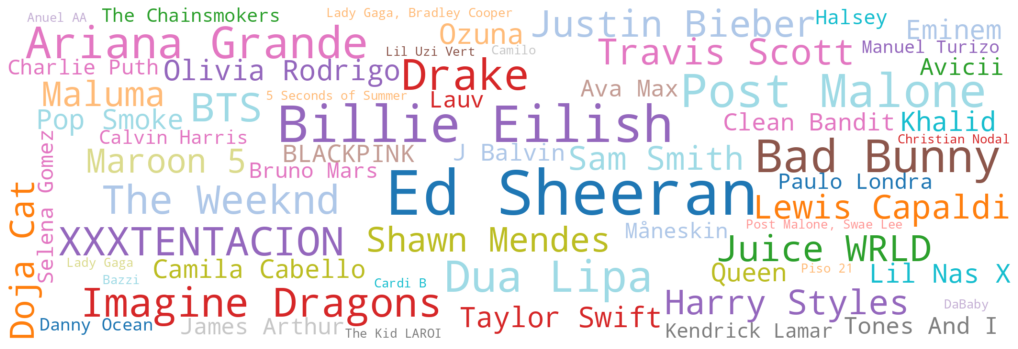

In [11]:
visualize_word_counts(counts)

We are going to compare the trend of songs between the most popular singer Ed Sheeran and the least popular singer Aspova to see the difference. From there we will try to suggest ways to improve their popularity.

# Streams by region
Which region's Top200 list is streamed the most? The result will be somewhat related to the region's population.

In [12]:
# compute total streams by region
streams = data.groupby('region')['streams'].sum().reset_index()

# compute percent stream
streams['percent_streams'] = streams['streams']/streams['streams'].sum()

# rename regions with very little streams (< .01 %) as 'Other'
streams['region'] = streams.apply(lambda x: x['region'] if x['percent_streams'] >= .01 else 'Other', axis=1)

# we need another groupby because there are multiple regions with name 'Other'
streams = streams.groupby('region')['percent_streams'].sum().reset_index().round(3).sort_values(by='percent_streams')

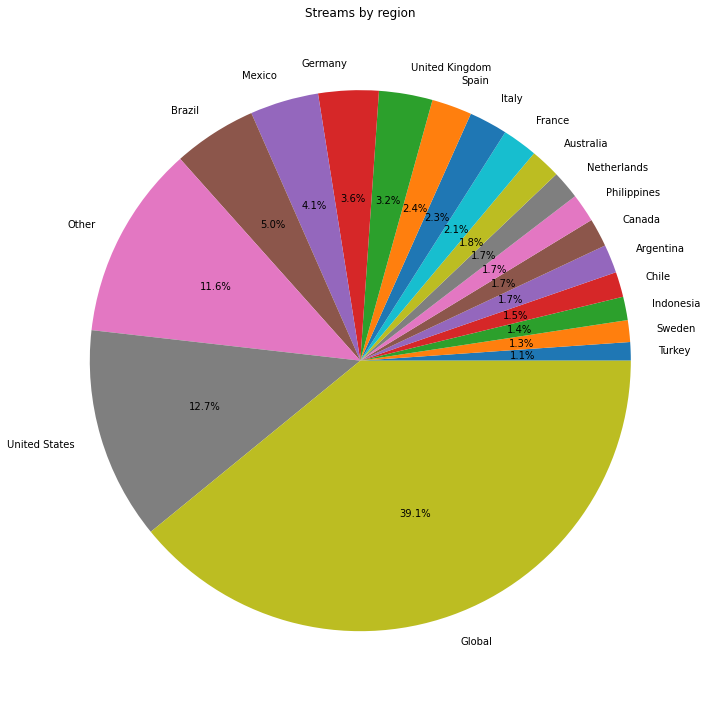

In [13]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.pie(x=streams['percent_streams'], labels=streams['region'], autopct='%.1f%%')
ax.set_title('Streams by region')
plt.tight_layout()

Now we try to use Spark and SQL to explore the trends in the dataset:

A SparkSession can be used create:
* DataFrame
* Register DataFrame as tables
* Execute SQL over tables
* Cache tables
* Read parquet files

To create a SparkSession, use the following builder pattern:

In [14]:
spark = (SparkSession.builder.config("spark.driver.memory","4g").config("spark.driver.maxResultSize", "4g").getOrCreate())

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/05/17 14:48:55 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Now, we need to import our data again. We are specifying the desire to use dataset csv format.
* “header”: true if the first row in the dataset are column names.
* “inferSchema” instructs Spark to attempt to infer the schema of the CSV

In [15]:
# import dataframe by spark
df = spark.read.csv(path='../input/spotify-charts/charts.csv', inferSchema=True, header=True)

We cannot perform our analysis with all the datatype string. Thus here we parse the datatypes using the format below.

Datatypes supported by Spark: https://spark.apache.org/docs/3.0.0-preview2/sql-ref-datatypes.html

We convert 'rank', 'date' and 'streams' in the original dataset to data types in Spark.

In [16]:
# setting the schema

df = df.withColumn("rank", f.col("rank").cast(t.IntegerType())).withColumn("date", f.col("date").cast(t.DateType())).withColumn("streams", f.col("streams").cast(t.IntegerType()))

Take a look at the DataFrame:

In [17]:
df

DataFrame[title: string, rank: int, date: date, artist: string, url: string, region: string, chart: string, trend: string, streams: int]

To perform analysis, we will be using spark sql library. For that, we create a temp table.

The reason to use the registerTempTable( tableName ) method for a DataFrame, is so that in addition to being able to use the Spark-provided methods of a DataFrame.

Using this, we can also issue SQL queries via the sqlContext. sql( sqlQuery ) method, that use that DataFrame as an SQL table.

In [18]:
# Register a temp table
df.registerTempTable("charts")

/opt/conda/lib/python3.7/site-packages/pyspark/sql/dataframe.py:140: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  FutureWarning


# Get the range of timeline of the data

In [19]:
spark.sql('''
SELECT MIN(date) begin, MAX(date) end 
FROM charts 
WHERE chart = 'top200';
''').toPandas()

,begin,end
0,2017-01-01,2021-12-31


# View the head of the chart

In [20]:
spark.sql('''
SELECT * 
FROM charts 
WHERE chart = 'top200' 
LIMIT 10;
''').toPandas()

,title,rank,date,artist,url,region,chart,trend,streams
0,Chantaje (feat. Maluma),1,2017-01-01,Shakira,https://open.spotify.com/track/6mICuAdrwEjh6Y6...,Argentina,top200,SAME_POSITION,253019
1,Vente Pa' Ca (feat. Maluma),2,2017-01-01,Ricky Martin,https://open.spotify.com/track/7DM4BPaS7uofFul...,Argentina,top200,MOVE_UP,223988
2,Reggaetón Lento (Bailemos),3,2017-01-01,CNCO,https://open.spotify.com/track/3AEZUABDXNtecAO...,Argentina,top200,MOVE_DOWN,210943
3,Safari,4,2017-01-01,"J Balvin, Pharrell Williams, BIA, Sky",https://open.spotify.com/track/6rQSrBHf7HlZjtc...,Argentina,top200,SAME_POSITION,173865
4,Shaky Shaky,5,2017-01-01,Daddy Yankee,https://open.spotify.com/track/58IL315gMSTD37D...,Argentina,top200,MOVE_UP,153956
5,Traicionera,6,2017-01-01,Sebastian Yatra,https://open.spotify.com/track/5J1c3M4EldCfNxX...,Argentina,top200,MOVE_DOWN,151140
6,Cuando Se Pone a Bailar,7,2017-01-01,Rombai,https://open.spotify.com/track/1MpKZi1zTXpERKw...,Argentina,top200,MOVE_DOWN,148369
7,Otra vez (feat. J Balvin),8,2017-01-01,Zion & Lennox,https://open.spotify.com/track/3QwBODjSEzelZyV...,Argentina,top200,MOVE_DOWN,143004
8,La Bicicleta,9,2017-01-01,"Carlos Vives, Shakira",https://open.spotify.com/track/0sXvAOmXgjR2QUq...,Argentina,top200,MOVE_UP,126389
9,Dile Que Tu Me Quieres,10,2017-01-01,Ozuna,https://open.spotify.com/track/20ZAJdsKB5IGbGj...,Argentina,top200,MOVE_DOWN,112012


# Get the total number of observations by all the singers in TOP 200 chart

In [21]:
spark.sql('''
SELECT COUNT(*) NoOfObservationsTop200
FROM charts 
WHERE chart = 'top200';
''').toPandas().head(10)

,NoOfObservationsTop200
0,20318183


=> Over 20 million observations in Top 200 over 4 years (1/1/2017 - 12/31/2021)

# Get the total number of songs by Ed Sheeran & Aspova appeared in Top 200

## Ed Sheeran

In [22]:
spark.sql('''
SELECT COUNT(DISTINCT title) NoOfSongs 
FROM charts 
WHERE artist LIKE '%Ed Sheeran%' AND chart = 'top200';
''').toPandas().head(10)

,NoOfSongs
0,121


## Aspova

In [23]:
spark.sql('''
SELECT COUNT(DISTINCT title) NoOfSongs 
FROM charts 
WHERE artist LIKE '%Aspova%' AND chart = 'top200';
''').toPandas().head(10)

,NoOfSongs
0,23


=> Ed Sheeran's songs appear in the Top 200 6 times more than Aspova's songs in the Top 200

# Count the number of times Ed Sheeran & Aspova appeared in the TOP 200 chart

## Ed Sheeran

In [24]:
spark.sql('''
SELECT COUNT(*) NoInTop200 
FROM charts 
WHERE artist LIKE '%Ed Sheeran%' AND chart = 'top200';
''').toPandas().head(10)

,NoInTop200
0,368388


## Aspova

In [25]:
spark.sql('''
SELECT COUNT(*) NoInTop200 
FROM charts 
WHERE artist LIKE '%Aspova%' AND chart = 'top200';
''').toPandas().head(10)

,NoInTop200
0,1344


=> Ed Sheeran appeared in the Top 200 300 times more than Aspova

# Count the number of times Ed Sheeran and Aspova appeared in the Top 200 while collaborating with other singers

## Ed Sheeran

In [26]:
spark.sql('''
SELECT artist, COUNT(artist) count 
FROM charts 
WHERE artist LIKE '%Ed Sheeran%' AND chart = 'top200' 
GROUP BY artist 
ORDER BY count DESC;
''').toPandas().head(10)

,artist,count
0,Ed Sheeran,366026
1,"Taylor Swift, Ed Sheeran, Future",1995
2,"Tori Kelly, Ed Sheeran",176
3,"Ed Sheeran, Elton John",125
4,"Fireboy DML, Ed Sheeran",19
5,"Alonestar, Rick Live, Ed Sheeran",14
6,"The Weeknd, Ed Sheeran",9
7,"Taylor Swift, Ed Sheeran",8
8,"Alonestar, HerbertSkillz, Ed Sheeran",8
9,"Foy Vance, Ed Sheeran",4


## Aspova

In [27]:
spark.sql('''
SELECT artist, COUNT(artist) count 
FROM charts 
WHERE artist LIKE '%Aspova%' AND chart = 'top200' 
GROUP BY artist 
ORDER BY count DESC;
''').toPandas().head(10)

,artist,count
0,Aspova,762
1,"Şanışer, Kamufle, Mert Şenel, Mirac, Aga B, De...",223
2,"Aspova, Şanışer",96
3,"Aspova, Tanerman",67
4,"Aspova, Patron",52
5,"Tuğkan, Aspova",42
6,"Aspova, Şehinşah",35
7,"Şanışer, Fuat, Ados, Hayki, Server Uraz, Beta ...",32
8,"Vio, Aspova",8
9,"Aspova, Motive, Murgs",7


=> Ed Sheeran and Aspova are both more successful solo.

=> Ed Sheeran's songs are 500 times more popular than Aspova's songs.